In [1]:
from evoVAE.utils.datasets import MSA_Dataset
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt
from evoVAE.models.seqVAETest import SeqVAETest
import pandas as pd
import torch
import numpy as np

pd.set_option("display.max_rows", None)

In [104]:
extants_aln = pd.read_pickle("../data/gfp/GFP_AEQVI_full_04-29-2022_b08_ancestors_extants_no_syn_no_dupes.pkl")

train_dataset = MSA_Dataset(extants_aln["encoding"], extants_aln["weights"], extants_aln["id"])
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=False
)

SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = train_dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * 21


config={
            # Dataset info
            "alignment": "tets",
            "seq_theta": 0.2,  # reweighting
            "AA_count": 21,  # standard AA + gap
            "test_split": 0.2,
            "max_mutation": 4,  # how many mutations the model will test up to
            # ADAM
            "learning_rate": 1e-2,  # ADAM
            "weight_decay": 1e-4,  # ADAM
            # Hidden units
            "momentum": None,
            "dropout": None,
            # Training loop
            "epochs": 500,
            "batch_size": 128,
            "max_norm": 10,  # gradient clipping
            "patience": 3,
            # Model info - default settings
            "architecture": f"SeqVAE_0.25_ancestors_R",
            "latent_dims": 3,
            "hidden_dims": [256, 128, 64],
            # DMS data
            "dms_file": "../data/SPG1_STRSG_Wu_2016.pkl",
            "dms_metadata": "../data/DMS_substitutions.csv",
            "dms_id": "SPG1_STRSG_Wu_2016",
}



SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = train_dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * 21


good_weights = "../data/gfp/model_weights/ancestors_extants_no_duplicates_gfp_model_state.pt"
bad_weights = "../data/gfp/model_weights/bad_loss/gfp_ancestors_extants_no_duplicates_model_state.pt"
model = SeqVAETest(input_dims, 3, hidden_dims=config["hidden_dims"], config=config)
model.load_state_dict(torch.load(good_weights))
model.eval()

SeqVAETest(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4998, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  )
  (z_mu_sampler): Linear(in_features=64, out_features=3, bias=True)
  (z_logvar_sampler): Linear(in_features=64, out_features=3, bias=True)
  (upscale_z): Linear(in_features=3, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Seque

In [105]:
sub = extants_aln.head()
ens = np.stack([x.flatten() for x in sub['encoding'].values])
sub


names = []
z_vals = []

count = 0 
num_samples = 50
# SAMPLE Z VALUES FROM THE MODEL FOR EACH EXTANT
for encoding, weights, name in train_loader:
    #print(encoding.shape)

    encoding = torch.flatten(encoding, start_dim=1)
    #print(encoding.shape)

    encoding = encoding.expand(num_samples, encoding.shape[0], encoding.shape[1])
    #print(encoding.shape)
    #print(encoding.shape)
    z_mu, z_logvar = model.encode(encoding.float())
    z_samples = model.reparameterise(z_mu, z_logvar)
    #print(z_samples.shape)
    #print(z_samples[:, 0, :])
    mean_z = torch.mean(z_samples, dim=0)
    #print(mean_z.shape)
    #print(mean_z[0, :])
    #print(list(name))
    #print(mean_z)
    
    names.extend(name)
    z_vals.extend(mean_z.detach().numpy())




print(len(names))
print(len(z_vals))
id_to_z = pd.DataFrame({"taxa": names, "z": z_vals})
id_to_z.tail()


673
673


,taxa,z
668,N34_tree_95,"[2.87482, -0.045414142, 1.1456146]"
669,N145_tree_95,"[3.0854034, 0.07532906, 1.3545245]"
670,N197_tree_95,"[2.948725, 0.09404379, 1.3480438]"
671,N198_tree_95,"[2.9598386, -0.029415376, 1.3052742]"
672,N210_tree_97,"[1.7500947, 0.0023063945, 2.367898]"


In [106]:

import torch.nn.functional as F
import evoVAE.utils.seq_tools as st
import evoVAE.utils.metrics as mt

count = 0
inputs = []
recons = []
hamming_dist = 0
# EVALUATE DIFFERENCES BETWEEN THE RECONSTRUCTIONS AND INPUT 
for id, z in zip(id_to_z['taxa'], id_to_z['z']):

    # decode the Z sample and get it into a PPM shape 
    x_hat = model.decode(torch.tensor(z))
    x_hat = x_hat.unsqueeze(-1)
    #print(x_hat.shape)

    x = extants_aln[extants_aln['id'] == id]['sequence'].values[0]
    x_one_hot = torch.tensor(st.seq_to_one_hot(x))
    #print(x_one_hot.shape)

    orig_shape = tuple(x_one_hot.shape)
    x_hat = x_hat.view(orig_shape)

    indices = x_hat.max(dim=-1).indices.tolist()
    
    orig = extants_aln[extants_aln['id'] == id]['sequence'].values[0]
    inputs.append(orig)
    recon = "".join([st.GAPPY_PROTEIN_ALPHABET[x] for x in indices])
    recons.append(recon)

    hamming_dist += mt.hamming_distance(orig, recon)
    count += 1
    

print(hamming_dist/count)
print(count)    


30.797919762258545
673


In [107]:
inputs[:5]

['MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK',
 'VSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTWGVQCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNAIHGNVYITADKQKNGIKANFGLNCNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSKLSKDPNEKRDHMVLLEFVTAARMQ--------',
 'VSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKLICTTGKLPVPWPTLVTTLGYGLMCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIED-----------------------------------------------------------------',
 'VSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKLICTTGKLPVPWPTLVTTLGYGLMCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHFVYITADKQKNGIKANFKIRHNIED-----------------------------------------------------------------',
 'MSKGEELFTGVVPILVELDGDVNGHK

In [108]:
recons[:5]

['-SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTISFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK',
 '-SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTISFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKANFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK',
 'VSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNFNSHNVYITADKQNAGIKAAFKIRDNIEDGSVMTADHYQQNTPLGD------------------------------------------------',
 'VSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLTYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNFNSHNVYITADKQNAGIKAAFKIRDNIEDGSVMTADHYQQNTPLGD------------------------------------------------',
 '-SKGEELFTGVVPILVELDGDVNGHK

# Visualisation of the latent space

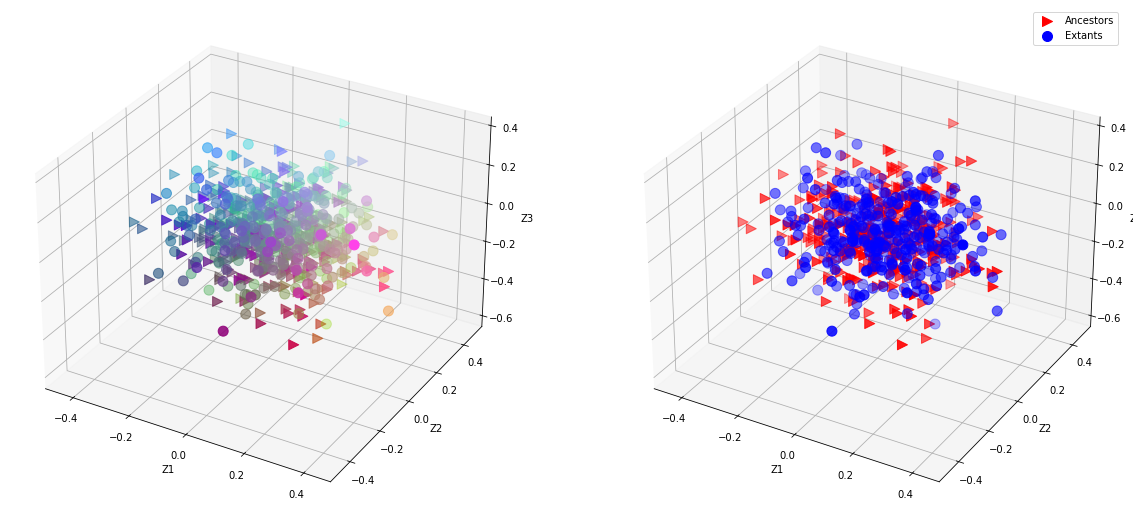

In [103]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Filter ancestors and extants
ancestors = id_to_z[id_to_z['taxa'].str.contains("tree")]
extants = id_to_z[~id_to_z['taxa'].str.contains("tree")]

# Combine dataframes
to_plot = pd.concat([ancestors, extants])

zs = np.array([z.tolist() for z in to_plot['z']])

# Scale Z values for RGB encoding
scaler = MinMaxScaler(feature_range=(0, 1))
rgb = scaler.fit_transform(zs)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,12),  subplot_kw={'projection': '3d'})

#ax1 = fig.add_subplot(111, projection='3d')

ax1.set_xlabel('Z1')
ax1.set_ylabel('Z2')
ax1.set_zlabel('Z3')

ax2.set_xlabel('Z1')
ax2.set_ylabel('Z2')
ax2.set_zlabel('Z3')

scaler = MinMaxScaler(feature_range=(0,1))

an_zs = np.array([z.tolist() for z in ancestors['z']])
ex_zs = np.array([z.tolist() for z in extants['z']])

an_rgb = scaler.fit_transform(an_zs)
ex_rgb = scaler.fit_transform(ex_zs)

# Plot ancestors
ax1.scatter(an_zs[:, 0], an_zs[:, 1], an_zs[:, 2], c=an_rgb, label='Ancestors', s=100, marker='>')
ax2.scatter(an_zs[:, 0], an_zs[:, 1], an_zs[:, 2], c='red', label='Ancestors', s=100, marker='>')
# Plot extants
ax1.scatter(ex_zs[:, 0], ex_zs[:, 1], ex_zs[:, 2], c=ex_rgb, label='Extants', s=100, marker='o')
ax2.scatter(ex_zs[:, 0], ex_zs[:, 1], ex_zs[:, 2], c='blue', label='Extants', s=100, marker='o')

ax2.legend()
plt.show()



# Annotation file for tree labeling

In [45]:

def rgb_to_hex(rgb):
    """Return color as #rrggbb for the given color values."""
    rounded_rgb = tuple(int(round(x)) for x in rgb)
    return '#%02X%02X%02X' % rounded_rgb

colours = [rgb_to_hex(i) for i in rgb]
id_to_z['colours'] = colours

In [49]:
id_to_z.to_csv("gfp_an_ex_annots.tsv", sep='\t', index=False)

In [48]:
id_to_z.head()

,taxa,z,colours
0,GFP_AEQVI/1-238,"[3.0430527, -0.04591151, 1.2991239]",#010101
1,UniRef100_UPI0011C34247/2-231,"[2.8637218, -0.89763165, 1.3173677]",#010001
2,UniRef100_UPI0011C34247/384-556,"[2.197786, -0.4052206, 1.8015774]",#010001
3,UniRef100_UPI0011C3426C/384-556,"[2.2174177, 0.11612219, 1.860413]",#010101
4,UniRef100_UPI001C2E920B/3-240,"[3.0992374, 1.2062294, 1.3076488]",#010101
